In [1]:
import os
import cv2
import ray
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib import image as img

from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, matthews_corrcoef



In [2]:
#
PATH = "./flowers/"
flower_types = [ "bougainvillea", "daisies",  "garden_roses", "gardenias", "hibiscus", "hydrangeas", "lilies", "orchids", "peonies", "tulip" ]

In [3]:
np.unique(
    list(
        map(lambda arr: "_".join(arr[:-1]),
            map(lambda file: file.split("_"), os.listdir(PATH))
        )
    )
)

array(['bougainvillea', 'daisies', 'garden_roses', 'gardenias',
       'hibiscus', 'hydrangeas', 'lilies', 'orchids', 'peonies', 'tulip'],
      dtype='<U13')

In [4]:
def get_filename(flower_type, idx = 0):
    flowers = list(filter(lambda filename: flower_type in filename, sorted(os.listdir(PATH)) ))
    return flowers[idx]

In [5]:
def read_image(filename):
    return img.imread(PATH + filename)

In [6]:
def get_image(type_idx=0, idx=0):
    return read_image(
        get_filename(flower_types[type_idx], idx)
    )

## Color Histogram Features

In [20]:
train_files, test_files = train_test_split(os.listdir("flowers/"), test_size=0.2, random_state=2)

In [21]:
y_train = list(map(lambda file: "_".join(file.split("_")[:-1]), train_files))

In [114]:
ray.init()

2023-03-03 00:00:00,903	INFO worker.py:1538 -- Started a local Ray instance.


RayContext(dashboard_url='', python_version='3.9.7', ray_version='2.2.0', ray_commit='b6af0887ee5f2e460202133791ad941a41f15beb', address_info={'node_ip_address': '127.0.0.1', 'raylet_ip_address': '127.0.0.1', 'redis_address': None, 'object_store_address': 'tcp://127.0.0.1:65378', 'raylet_socket_name': 'tcp://127.0.0.1:65172', 'webui_url': '', 'session_dir': 'C:\\Users\\joelp\\AppData\\Local\\Temp\\ray\\session_2023-03-02_23-59-58_302219_280', 'metrics_export_port': 63810, 'gcs_address': '127.0.0.1:64271', 'address': '127.0.0.1:64271', 'dashboard_agent_listen_port': 52365, 'node_id': '9b463ea143ca182415a7829a1ec03c66424e3f113b5e3e33c229786f'})

In [138]:
@ray.remote
def get_histogram(i, file):
    if i%50==0:
        print(i)
    
    x = []
    temp = read_image(file)
    for channel in range(3):
        bin_counts, _ = np.histogram(
                temp[:,:,channel].ravel(),
                bins=8,
                range=(0,255)
        )
        
        x = np.hstack((x, bin_counts))

    return x.reshape(-1,1).T

def get_hist_feat(files):
    X = np.empty((0, 8*3))
    
    res = []
    for i, file in enumerate(files):
        res.append( get_histogram.remote(i, file) )
    data = ray.get(res)

    print("Processing Finished.\nAppending data...")
    
    for x in data:
        X = np.concatenate((X, x), axis=0)
    return X
    

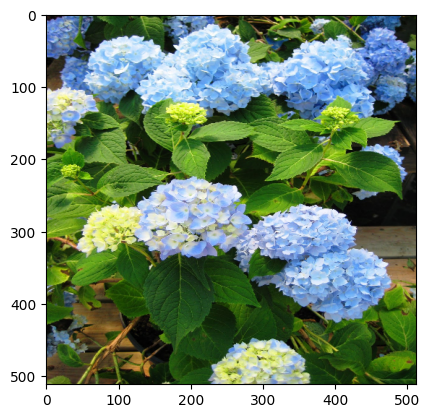

In [33]:
plt.imshow(cv2.resize(read_image(train_files[0]), (512,512)))


In [50]:
np.histogram(cv2.resize(read_image(train_files[0]), (512,512)),
       bins=8,
       range=(0,255))[0]/np.histogram(cv2.resize(read_image(train_files[0]), (512,512)),
       bins=8,
       range=(0,255))[0].sum()

array([0.2445844 , 0.15355174, 0.12554932, 0.11116409, 0.09273911,
       0.08747864, 0.08357493, 0.10135778])

In [51]:
@ray.remote
def get_gray_histogram(i, file, size):
    if i%50==0:
        print(i)
    
    temp = cv2.resize(read_image(file), size)
    x = np.histogram(
        temp.mean(axis=2).ravel(),
        bins=8,
        range=(0,255)
    )[0]
    x=x/x.sum()

    return x.reshape(-1,1).T

def get_gray_hist_feat(files, width=512, heigth=512):
    X = np.empty((0, 8))
    
    res = []
    size = (width, heigth)
    for i, file in enumerate(files):
        res.append( get_gray_histogram.remote(i, file, size) )
    data = ray.get(res)

    print("Processing Finished.\nAppending data...")
    
    for x in data:
        X = np.concatenate((X, x), axis=0)
    return X
    

In [52]:
X_train = get_gray_hist_feat(train_files)

(get_gray_histogram pid=15624) 0
(get_gray_histogram pid=15624) 50
(get_gray_histogram pid=4888) 100
(get_gray_histogram pid=10352) 150
(get_gray_histogram pid=4888) 200
(get_gray_histogram pid=11844) 250
(get_gray_histogram pid=4888) 300
(get_gray_histogram pid=10352) 350
(get_gray_histogram pid=10352) 400
(get_gray_histogram pid=10352) 450
(get_gray_histogram pid=15624) 500
(get_gray_histogram pid=11844) 550
Processing Finished.
Appending data...


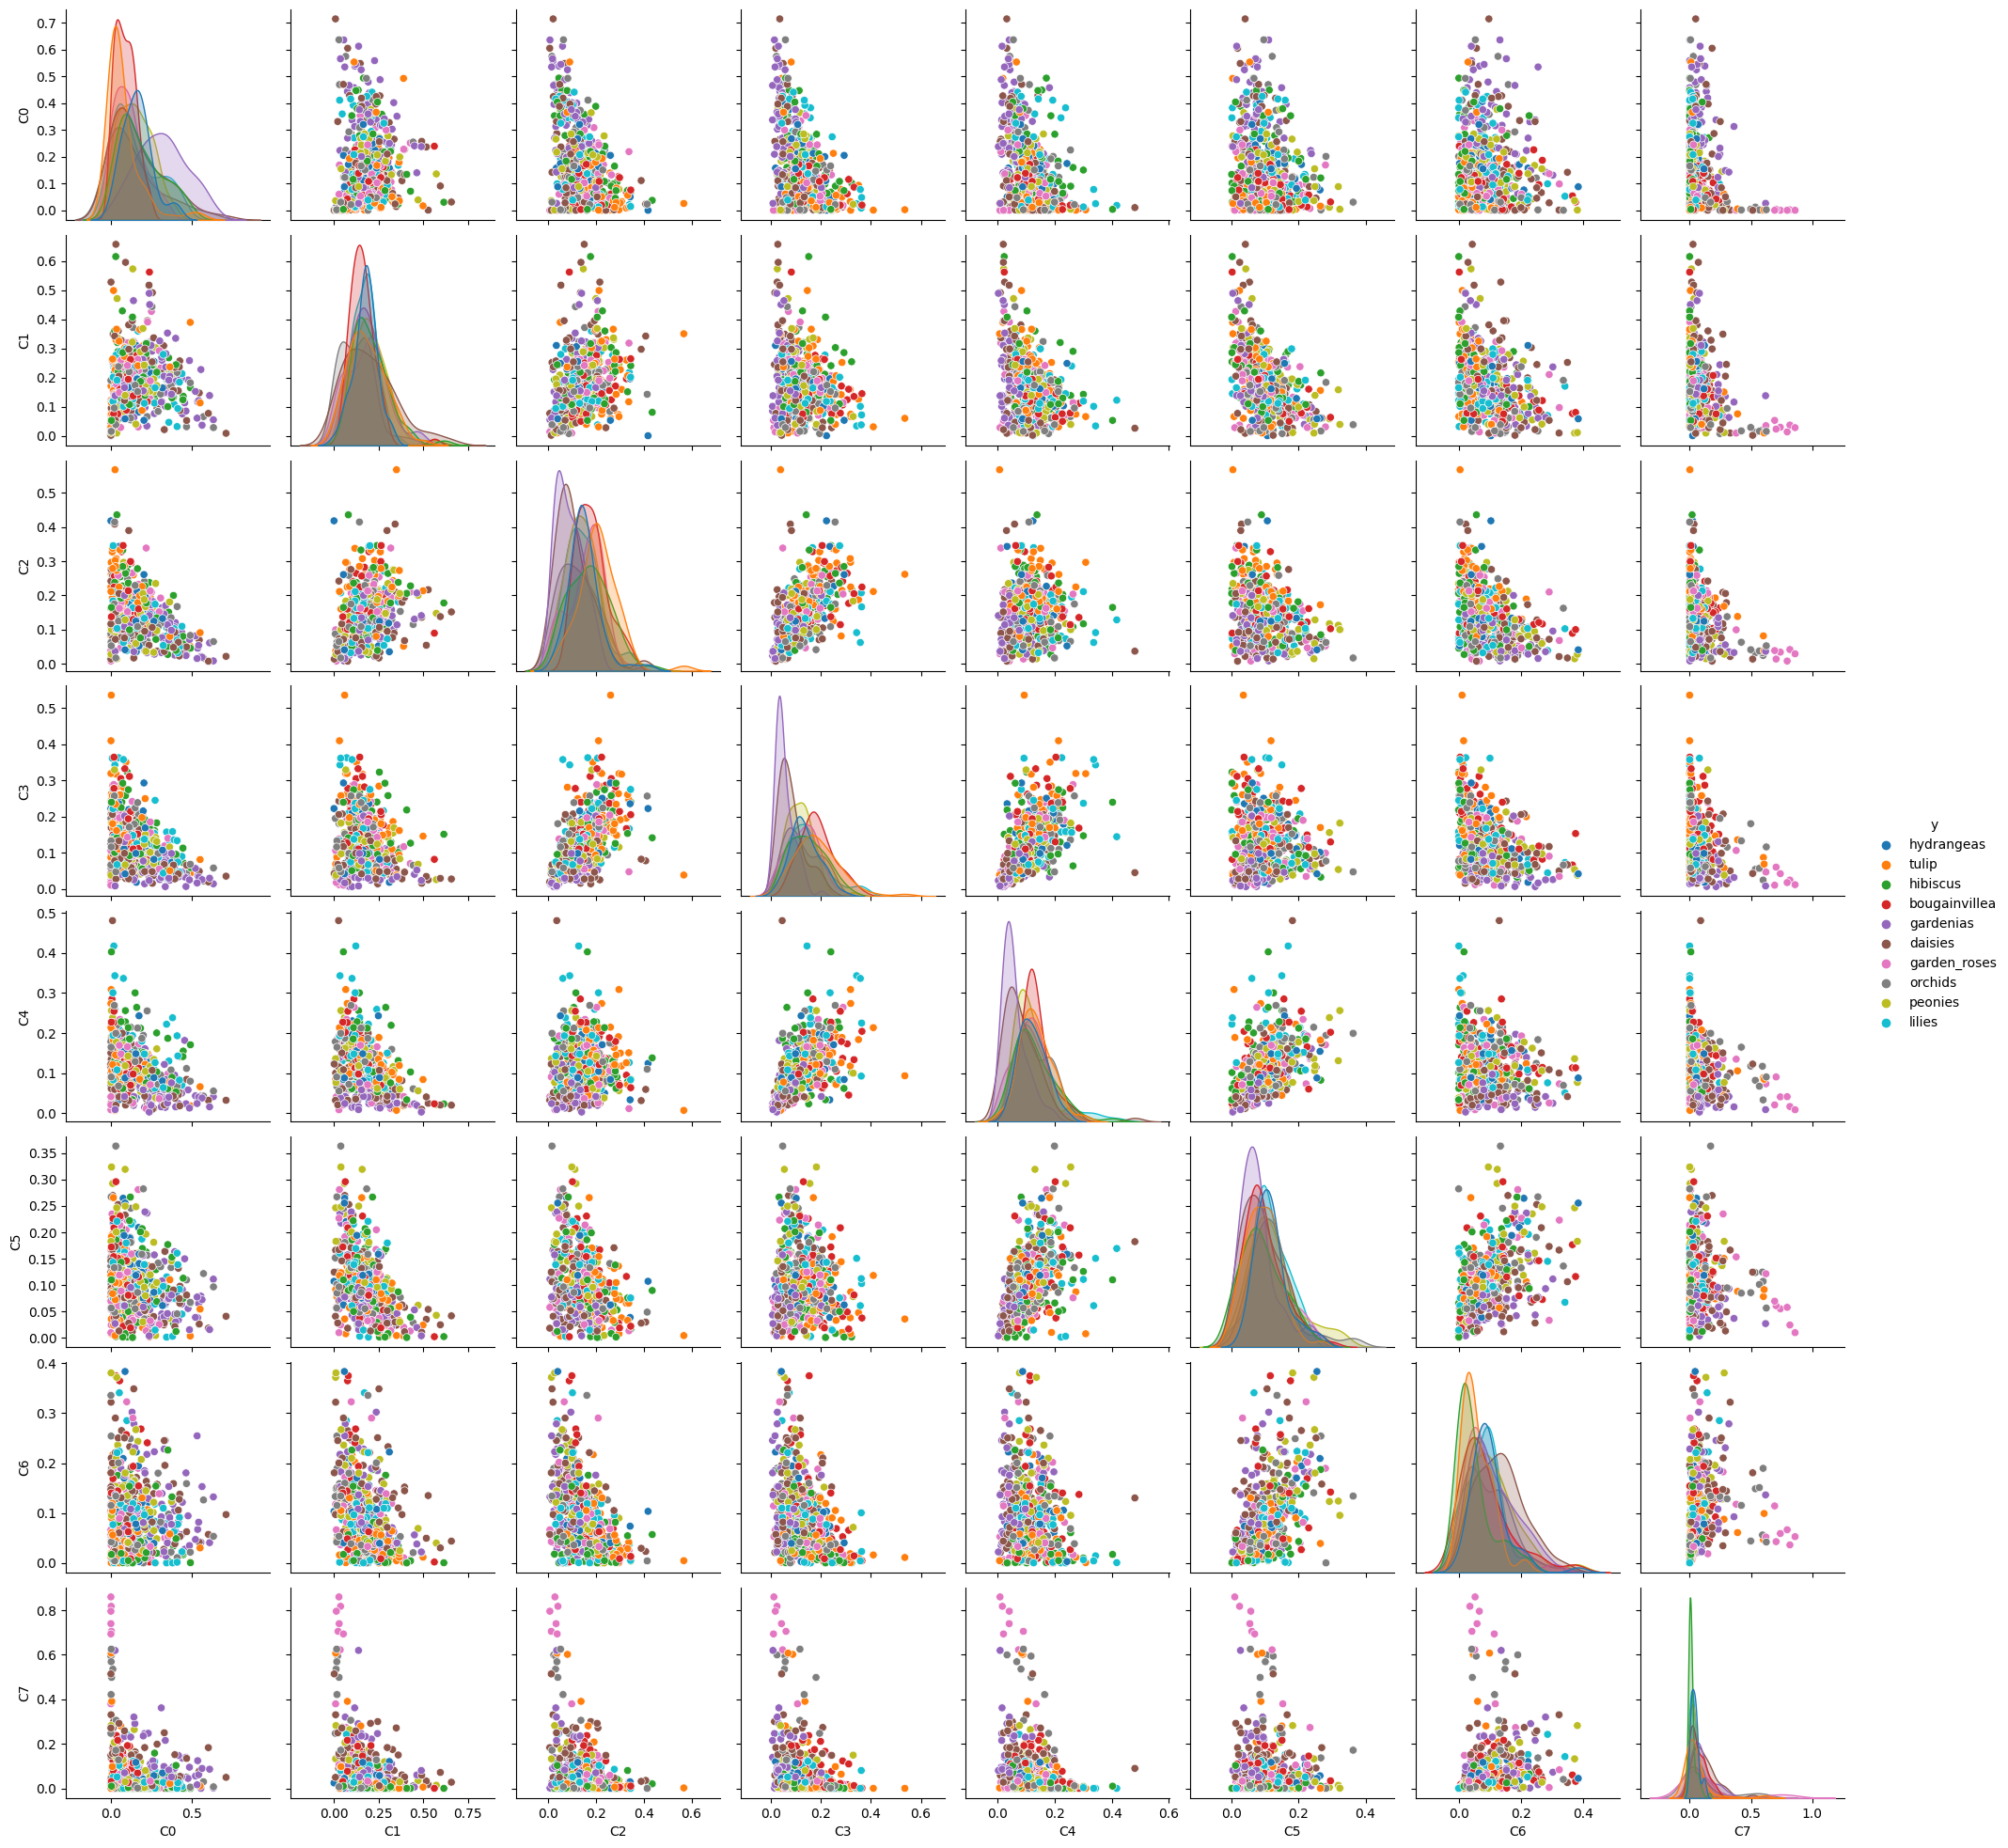

In [53]:
sns.pairplot(pd.concat(
        ( pd.DataFrame(
            data=X_train, 
            columns=[f"C{i}" for i in range(8)]
          ), 
          pd.DataFrame(
              data=y_train, 
              columns=["y"]
          )
    ), axis = 1
    )
    , hue="y"
)

In [54]:
ray.shutdown()

In [55]:
enc = LabelEncoder().fit(y_train)

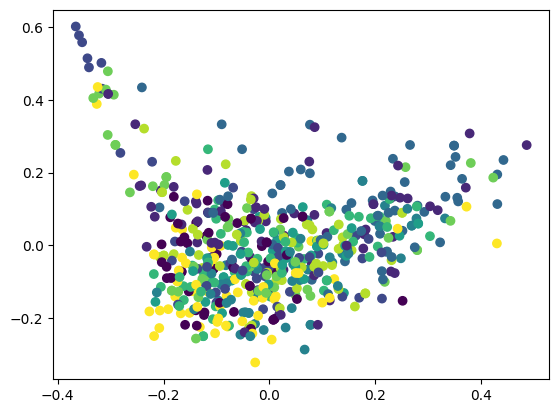

In [56]:
reduced_x = PCA(n_components=2).fit_transform(X_train)
plt.scatter(reduced_x[:,0], reduced_x[:,1], c = enc.transform(y_train) )

## Prediction Using Color Histogram with Linearly spaced Bins

In [7]:
def plot_hist_rgb(image, title="", size=(14,4), kmeans=True):
    f, ax = plt.subplots(1, image.shape[-1], figsize=size)
    colors = ["r", "g", "b"]
    for i in range(image.shape[-1]):
        #ax[i].hist(image[:,:,i])
        if kmeans:
            KMeans().fit(image[:,:,i])
        else:
            sns.histplot(
                image[:,:,i].flat, 
                ax=ax[i], 
                color=colors[i]
            ).set(
                title=f"{colors[i].upper()} Channel"
            )
        
    f.suptitle(title)
    f.tight_layout()
    

In [8]:
def plot_hist_triplets(image, size=(8,4)):
    sns.histplot(image.mean(axis=2).flat)
    plt.figure()
    sns.histplot(image.ravel())
    #triplets = pd.Series(list(map(lambda r,g,b: (r,g,b), image[:,:,0].flat, image[:,:,1].flat, image[:,:,2].flat))).value_counts()
    #sns.histplot(triplets)
    #print( pd.Series.value_counts(triplets) )
    #sns.histplot(x=triplets.index, y=triplets)

In [11]:
class Histogram_Model():
    def __init__(
        self,
        #n_clusters=8,
        predicter = SVC()
    ):
        #self.cluster = KMeans(n_clusters)
        self.scaler = MinMaxScaler()
        self.encoder = LabelEncoder()
        self.predicter=predicter
    
    def get_X_histograms(self, X):
        pass
    
    def fit(self, X, y):
        #self.red_cluster = self.cluster.fit( X[:,:,0]) 
        histogram_X = self.get_X_histograms(X)
        self.encoder = self.encoder.fit(y)
        
        self.y = self.encoder.transform(y)
        self.X = np.array(histogram_X)
        self.predicter = self.predicter.fit(self.X, self.y)
        return self
    
    def predict(self, X):
        histogram_X = self.get_X_histograms(X)
        X = np.array(histogram_X)
        return self.predicter.predict(X)

In [79]:
m = KMeans(n_clusters=8).fit(get_image(type_idx,idx)[:,:,2].reshape(-1,1))
m.cluster_centers_

array([[174.88662004],
       [ 10.83264591],
       [ 83.15484039],
       [ 28.79677224],
       [146.65841066],
       [ 53.80428504],
       [114.24998022],
       [  2.33944884]])

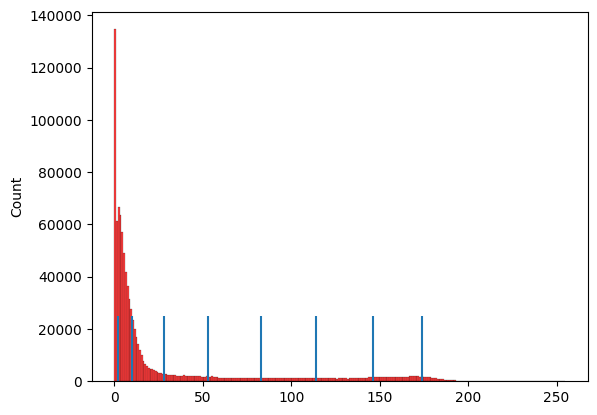

In [80]:
plt.figure()
sns.histplot(get_image(type_idx,idx)[:,:,2].flat, color="r", bins=256)
#sns.histplot(m.cluster_centers_.astype("int16"), color="b")
plt.vlines(m.cluster_centers_.astype("int16"), ymin=0, ymax=25000)

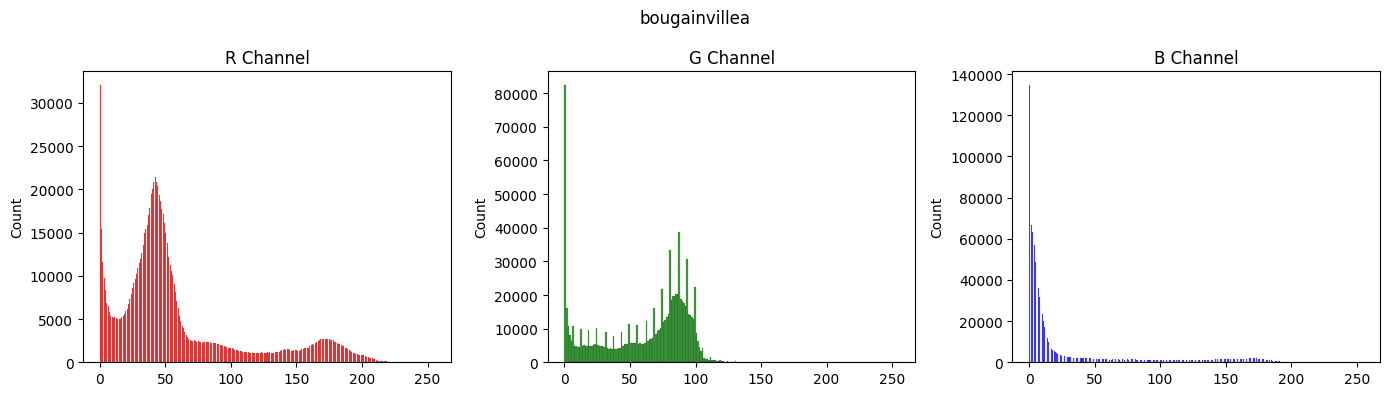

In [76]:
type_idx=0
idx=2
plot_hist_rgb(
    get_image(type_idx,idx), flower_types[type_idx]
)

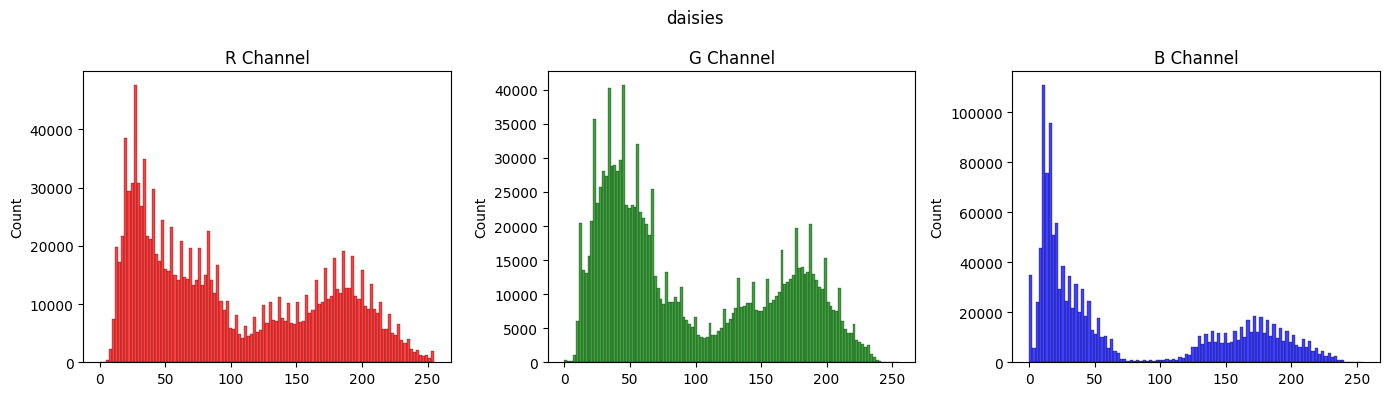

In [73]:
type_idx=1
idx=1
plot_hist_rgb(
    get_image(1,idx), flower_types[1]
)

### Using Separate RGB channels separate, as features

In [15]:
class Histogram_Model_RGB(Histogram_Model):
    def get_X_histograms(self, X):
        histogram_X = []
        for image in X:
            bins=np.empty(shape=(0))
            for dim in range(3):
                channel_bins = np.histogram(
                    image[:,:,dim], 
                    8, 
                    range=(0,255)
                )[0]
                channel_bins = self.scaler.fit_transform(
                    channel_bins.reshape(-1,1)
                ).ravel()
                bins = np.concatenate(
                    (bins, channel_bins)
                )
            histogram_X.append(bins)
        return histogram_X

In [49]:
m = Histogram_Model_RGB(predicter=KNN()).fit(X_train, y_train)

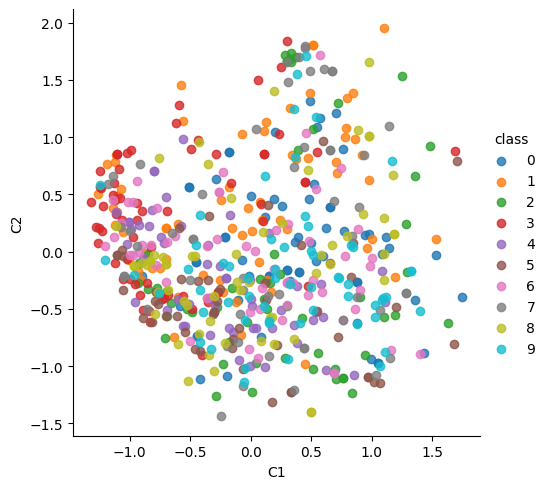

In [21]:
pca=PCA(n_components=2).fit(m.X)
pca_x=pca.transform(m.X)
temp_df=pd.DataFrame(data={"C1": pca_x[:,0], "C2": pca_x[:,1], "class":m.y})
sns.lmplot(temp_df, x="C1", y="C2", hue="class", fit_reg=False)

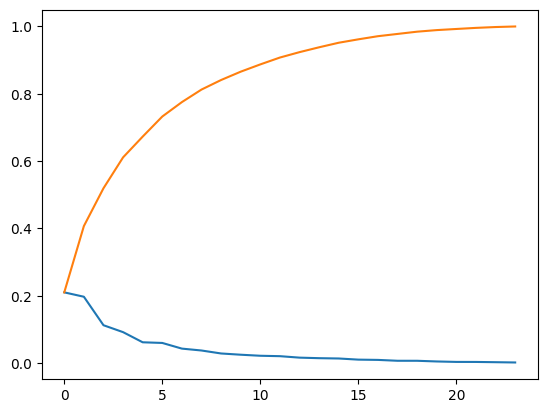

In [22]:
plt.plot(PCA().fit(m.X).explained_variance_ratio_)
plt.plot(PCA().fit(m.X).explained_variance_ratio_.cumsum())

The principle components seem to indicate that there are features that create a linear separation from the classes and that the features selected do not cluster the groups

In [50]:
preds = m.predict(X_train)

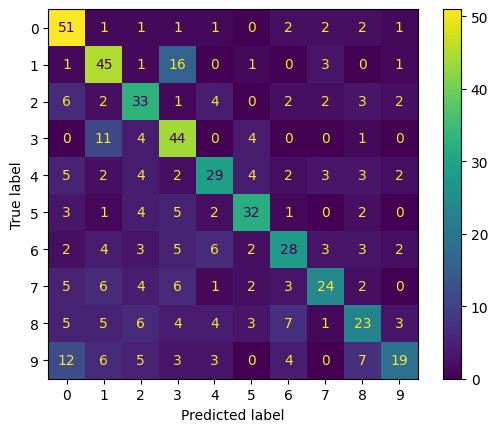

In [ ]:
ConfusionMatrixDisplay(
    confusion_matrix(m.encoder.transform(y_train), preds)
).plot()

In [52]:
print(classification_report(m.encoder.transform(y_train), preds))

              precision    recall  f1-score   support

           0       0.57      0.82      0.67        62
           1       0.54      0.66      0.60        68
           2       0.51      0.60      0.55        55
           3       0.51      0.69      0.58        64
           4       0.58      0.52      0.55        56
           5       0.67      0.64      0.65        50
           6       0.57      0.48      0.52        58
           7       0.63      0.45      0.53        53
           8       0.50      0.38      0.43        61
           9       0.63      0.32      0.43        59

    accuracy                           0.56       586
   macro avg       0.57      0.56      0.55       586
weighted avg       0.57      0.56      0.55       586



In [53]:
matthews_corrcoef(m.encoder.transform(y_train), preds) 

0.5123050978293504

The results Are not Decent even in the training set

### Merging RGB channels into Single Channel

In [40]:
class Histogram_Model_Single_Channel(Histogram_Model):
    def get_X_histograms(self, X):
        histogram_X = []
        for image in X:
            bins = np.histogram(image.ravel(), 8, range=(0,255))[0]
            bins = self.scaler.fit_transform(bins.reshape(-1,1)).ravel()
            histogram_X.append(bins)
        return histogram_X

In [ ]:
X, y = get_all_data()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

In [41]:
m = Histogram_Model_Single_Channel().fit(X_train, y_train)

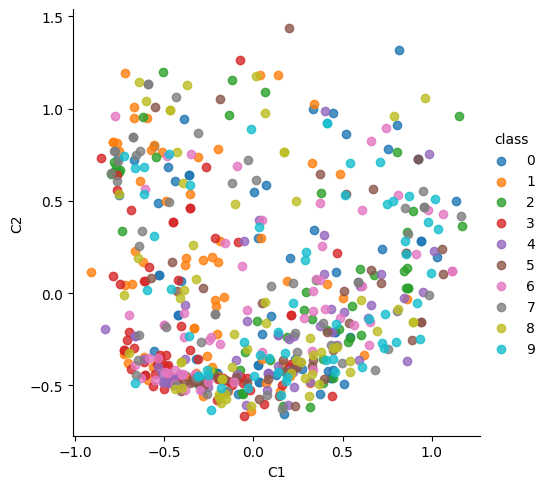

In [42]:
pca=PCA(n_components=2).fit(m.X)
pca_x=pca.transform(m.X)
temp_df=pd.DataFrame(data={"C1": pca_x[:,0], "C2": pca_x[:,1], "class":m.y})
sns.lmplot(temp_df, x="C1", y="C2", hue="class", fit_reg=False)

In [43]:
preds = m.predict(X_train)

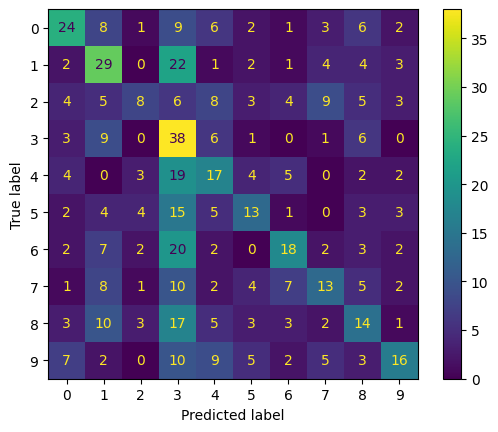

In [44]:
ConfusionMatrixDisplay(
    confusion_matrix(m.encoder.transform(y_train), preds)
).plot()

In [45]:
print(classification_report(m.encoder.transform(y_train), preds))

              precision    recall  f1-score   support

           0       0.46      0.39      0.42        62
           1       0.35      0.43      0.39        68
           2       0.36      0.15      0.21        55
           3       0.23      0.59      0.33        64
           4       0.28      0.30      0.29        56
           5       0.35      0.26      0.30        50
           6       0.43      0.31      0.36        58
           7       0.33      0.25      0.28        53
           8       0.27      0.23      0.25        61
           9       0.47      0.27      0.34        59

    accuracy                           0.32       586
   macro avg       0.35      0.32      0.32       586
weighted avg       0.35      0.32      0.32       586



In [46]:
matthews_corrcoef(m.encoder.transform(y_train), preds) 

0.2517242222836271

Single Channel Results were even worst

## Prediction using Histogram with Unsupervised Bin Selection

In [33]:
X,y=get_all_data(False)

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=2)
del X,y

In [8]:
class Histogram_Model_Cluster_Bins():
    def __init__(
        self,
        n_clusters=8,
        predicter = SVC()
    ):
        self.clusters = [KMeans(n_clusters)]
        self.scaler = MinMaxScaler()
        self.encoder = LabelEncoder()
        self.predicter=predicter
    
    def get_X_histograms(self, X):
        pass
    
    def fit(self, X, y):
        histogram_X = self.get_X_histograms(X)
        self.encoder = self.encoder.fit(y)
        
        self.y = self.encoder.transform(y)
        self.X = np.array(histogram_X)
        self.predicter = self.predicter.fit(self.X, self.y)
        return self
    
    def predict(self, X):
        histogram_X = self.get_X_histograms(X)
        X = np.array(histogram_X)
        return self.predicter.predict(X)

### Using RGB channels

In [11]:
class Histogram_Model_Cluster_Bins_RGB(Histogram_Model_Cluster_Bins):    
    def __init__(self, n_clusters=8, predicter=SVC()):
        super().__init__(n_clusters, predicter)
        self.clusters = [KMeans(n_clusters) for i in range(3)]
        
    def get_X_histograms(self, X):
        for i, cluster in zip( range(3), self.clusters):
            channel = np.concatenate([ arr[:,:,i].ravel() for arr in X ])
            self.custers[i] = cluster.fit(channel.reshape(-1,1))
        
        histogram_X = []
        for image in X:
            bins=np.empty(shape=(0))
            for dim, cluster in zip(range(3), self.clusters):
                channel_bins = np.histogram(
                    image[:,:,dim], 
                    bins=cluster.cluster_centers_.astype("uint16").sort(), 
                    range=(0,255)
                )[0]
                channel_bins = self.scaler.fit_transform(
                    channel_bins.reshape(-1,1)
                ).ravel()
                bins = np.concatenate(
                    (bins, channel_bins)
                )
            histogram_X.append(bins)
        return histogram_X
    
    def fit(self, X, y):
        histogram_X = self.get_X_histograms(X)
        self.encoder = self.encoder.fit(y)
        
        self.y = self.encoder.transform(y)
        self.X = np.array(histogram_X)
        self.predicter = self.predicter.fit(self.X, self.y)
        return self
    
    def predict(self, X):
        histogram_X = self.get_X_histograms(X)
        X = np.array(histogram_X)
        return self.predicter.predict(X)

### Using Single Channel

In [ ]:
class Histogram_Model_Cluster_Bins_SingleChannel(Histogram_Model_Cluster_Bins):    
    def get_X_histograms(self, X):
        for file in X:
            
        channel = np.concatenate([ arr[:,:,i].ravel() for arr in X ])
        self.custers[0] = cluster.fit(channel.reshape(-1,1))
        
        histogram_X = []
        for image in X:
            bins = np.histogram(
                image[:,:,dim], 
                bins=cluster.cluster_centers_.astype("uint16").sort(), 
                range=(0,255)
            )[0]
            
            bins = self.scaler.fit_transform(
                bins.reshape(-1,1)
            ).ravel()
            
            histogram_X.append(bins)
        return histogram_X
    
    def fit(self, X, y):
        histogram_X = self.get_X_histograms(X)
        self.encoder = self.encoder.fit(y)
        
        self.y = self.encoder.transform(y)
        self.X = np.array(histogram_X)
        self.predicter = self.predicter.fit(self.X, self.y)
        return self
    
    def predict(self, X):
        histogram_X = self.get_X_histograms(X)
        X = np.array(histogram_X)
        return self.predicter.predict(X)

In [42]:
temp = np.concatenate( [ read_image(file).mean(axis=2).ravel() for file in X_train ] ).reshape(-1,1)

In [43]:
c = MiniBatchKMeans().fit(temp)

MemoryError: Unable to allocate 9.68 GiB for an array with shape (1299226720,) and data type float64

## Color Correlogram

In [19]:
import ray

ray.init()


2023-02-25 15:29:19,998	INFO worker.py:1538 -- Started a local Ray instance.


RayContext(dashboard_url='', python_version='3.9.7', ray_version='2.2.0', ray_commit='b6af0887ee5f2e460202133791ad941a41f15beb', address_info={'node_ip_address': '127.0.0.1', 'raylet_ip_address': '127.0.0.1', 'redis_address': None, 'object_store_address': 'tcp://127.0.0.1:60974', 'raylet_socket_name': 'tcp://127.0.0.1:58764', 'webui_url': '', 'session_dir': 'C:\\Users\\joelp\\AppData\\Local\\Temp\\ray\\session_2023-02-25_15-29-15_246655_6132', 'metrics_export_port': 61778, 'gcs_address': '127.0.0.1:56980', 'address': '127.0.0.1:56980', 'dashboard_agent_listen_port': 52365, 'node_id': 'dfe9aae79bd6e17200be4f49612a108609c806169adc5efb499ea1e1'})

In [24]:
@ray.remote
def get_all_histogram():
    counts = dict(zip(range(256), [0] * 256))
    for file in os.listdir(PATH):
        temp = read_image(file)
        for value in temp.ravel():
            counts[value]+=1
    return counts

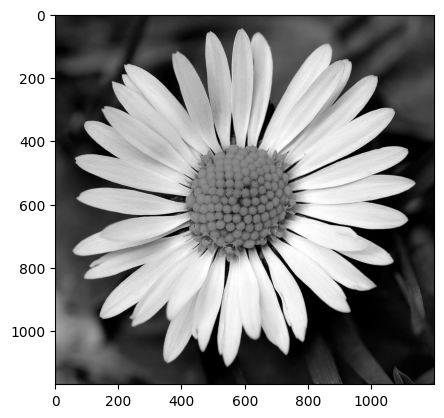

In [36]:
plt.imshow(get_image(1).mean(axis=2), cmap="gray")

In [40]:
get_image(1).mean(axis=2).astype("uint16")

array([[ 44,  44,  44, ...,  41,  39,  36],
       [ 44,  44,  44, ...,  42,  39,  37],
       [ 44,  44,  44, ...,  42,  40,  38],
       ...,
       [102, 101, 100, ...,  33,  26,  19],
       [102, 101, 100, ...,  30,  18,   8],
       [101, 102, 103, ...,  15,   9,   8]], dtype=uint16)

# Texture

In [7]:
from skimage.feature import graycomatrix
from pyfeats.textural import glcm_features
from random import shuffle

## Gray Level Co-ocurrence Matrix

In [7]:
get_image(1).mean(axis=2).astype("uint16")

array([[ 44,  44,  44, ...,  41,  39,  36],
       [ 44,  44,  44, ...,  42,  39,  37],
       [ 44,  44,  44, ...,  42,  40,  38],
       ...,
       [102, 101, 100, ...,  33,  26,  19],
       [102, 101, 100, ...,  30,  18,   8],
       [101, 102, 103, ...,  15,   9,   8]], dtype=uint16)

In [10]:
def glcm(img, n_values, quantization=1):
    M = np.zeros(shape=(n_values, n_values))
    
    w = int(img.shape[1]/quantization)
    h = int(img.shape[0]/quantization)
    
    img = cv2.resize(img, (w,h))
    
    for i in range(img.shape[0]):
        for j in range(img.shape[0]-1):
            M[ img[i,j], img[i,j+1] ] += 1
    return M/M.sum()

In [12]:
def get_angular_moment(glcm):
    return (glcm**2).sum()

def get_contrast(glcm):
    n = glcm.shape[0]
    contrast = np.abs(
        np.array( 
            [[i for j in range(n)] for i in range(n)]
        ) - np.array( 
            [ list(range(n)) for i in range(n) ]
        ),
        dtype=float
    )**2
    contrast*=glcm
    return contrast.sum()

def get_correlation(glcm):
    #TODO fix this function
    mean_x, mean_y = glcm.mean(axis=0), glcm.mean(axis=1)
    std_x, std_y = glcm.std(axis=0), glcm.std(axis=1)

    i_pos = np.array( [[i for j in range(n)] for i in range(n)] )
    j_pos = np.array( [ list(range(n)) for i in range(n) ] )
    
    return ( ( (i_pos - mean_x)*(j_pos - mean_y)*glcm) / (std_x * std_y) ).sum()

def get_ssv(glcm):
    u = glcm.mean()
    n = glcm.shape[0]
    i = np.array( [[i for j in range(n)] for i in range(n)] )
    
    return ((i - u)**2 * glcm).sum()

def get_inverse_dif_moment(glcm):
    n = glcm.shape[0]
    i_pos = np.array( [[i for j in range(n)] for i in range(n)] )
    j_pos = np.array( [ list(range(n)) for i in range(n) ] )
    
    temp = 1 / (1 + (i_pos - j_pos)**2)
    return (glcm * temp).sum()

In [22]:
get_angular_moment(glcm(
    get_image(1).mean(axis=2).astype("uint16"),
    256,
    1
))

0.0015539735205932804

In [19]:
dict(
    zip(
        glcm_features(get_image(1).mean(axis=2).astype("uint16"))[2],
        glcm_features(get_image(1).mean(axis=2).astype("uint16"))[0],
    )
)

{'GLCM_ASM_Mean': 0.0006677368397308315,
 'GLCM_Contrast_Mean': 180.1202581309808,
 'GLCM_Correlation_Mean': 0.9877178507936774,
 'GLCM_SumOfSquaresVariance_Mean': 7333.323627460432,
 'GLCM_InverseDifferenceMoment_Mean': 0.40300958819506993,
 'GLCM_SumAverage_Mean': 250.17316305997528,
 'GLCM_SumVariance_Mean': 29153.174251710738,
 'GLCM_SumEntropy_Mean': 8.726537583293533,
 'GLCM_Entropy_Mean': 11.699856853926114,
 'GLCM_DifferenceVariance_Mean': 0.0006285976217217841,
 'GLCM_DifferenceEntropy_Mean': 3.3472211537421774,
 'GLCM_Information1_Mean': -0.4875542446994366,
 'GLCM_Information2_Mean': 0.9997144942600898,
 'GLCM_MaximalCorrelationCoefficient_Mean': 4.013193256372533}

In [8]:
feat_labels = glcm_features(get_image(1).mean(axis=2).astype("uint16"))[2]

In [9]:
train_files, test_files = train_test_split(os.listdir("flowers/"), test_size=0.2, random_state=2)

In [10]:
ray.init()

2023-03-03 20:24:27,568	INFO worker.py:1538 -- Started a local Ray instance.


RayContext(dashboard_url='', python_version='3.9.7', ray_version='2.2.0', ray_commit='b6af0887ee5f2e460202133791ad941a41f15beb', address_info={'node_ip_address': '127.0.0.1', 'raylet_ip_address': '127.0.0.1', 'redis_address': None, 'object_store_address': 'tcp://127.0.0.1:63914', 'raylet_socket_name': 'tcp://127.0.0.1:59368', 'webui_url': '', 'session_dir': 'C:\\Users\\joelp\\AppData\\Local\\Temp\\ray\\session_2023-03-03_20-24-23_856129_2960', 'metrics_export_port': 58343, 'gcs_address': '127.0.0.1:57179', 'address': '127.0.0.1:57179', 'dashboard_agent_listen_port': 52365, 'node_id': '50158c512c50e8290d90da19df843da73c425ccdaab7542ad4120cf3'})

In [13]:
@ray.remote
def get_image_texture_and_class(i, file, size):
    if (i%50==0): print(i)
    x = glcm_features(
        cv2.resize(read_image(file), size)
    )[0].reshape(-1,1).T

    return x

def get_images_texture_and_classes(files, width=512, height=512):
    X = np.empty(shape=(0, 14))
    
    res = []
    for i, file in enumerate(files):
        size = (width, height)
        res.append( get_image_texture_and_class.remote(i, file, size) ) 
    xys = ray.get(res)
    
    print("Concluded processing the data.\nAppending...")
    
    for x_values in xys:
        X = np.concatenate((X, x_values), axis=0)

    return X

In [14]:
X_train = get_images_texture_and_classes(train_files)

(get_image_texture_and_class pid=9836) 0
(get_image_texture_and_class pid=8748) 50
(get_image_texture_and_class pid=25376) 100
(get_image_texture_and_class pid=25376) 150
(get_image_texture_and_class pid=25376) 200
(get_image_texture_and_class pid=25376) 250
(get_image_texture_and_class pid=8748) 300
(get_image_texture_and_class pid=25376) 350
(get_image_texture_and_class pid=9836) 400
(get_image_texture_and_class pid=24800) 450
(get_image_texture_and_class pid=24800) 500
(get_image_texture_and_class pid=24800) 550
Concluded processing the data.
Appending...


In [15]:
y_train = list(map(lambda x: "_".join(x.split("_")[:-1]), train_files))

In [16]:
enc = LabelEncoder().fit(y_train)

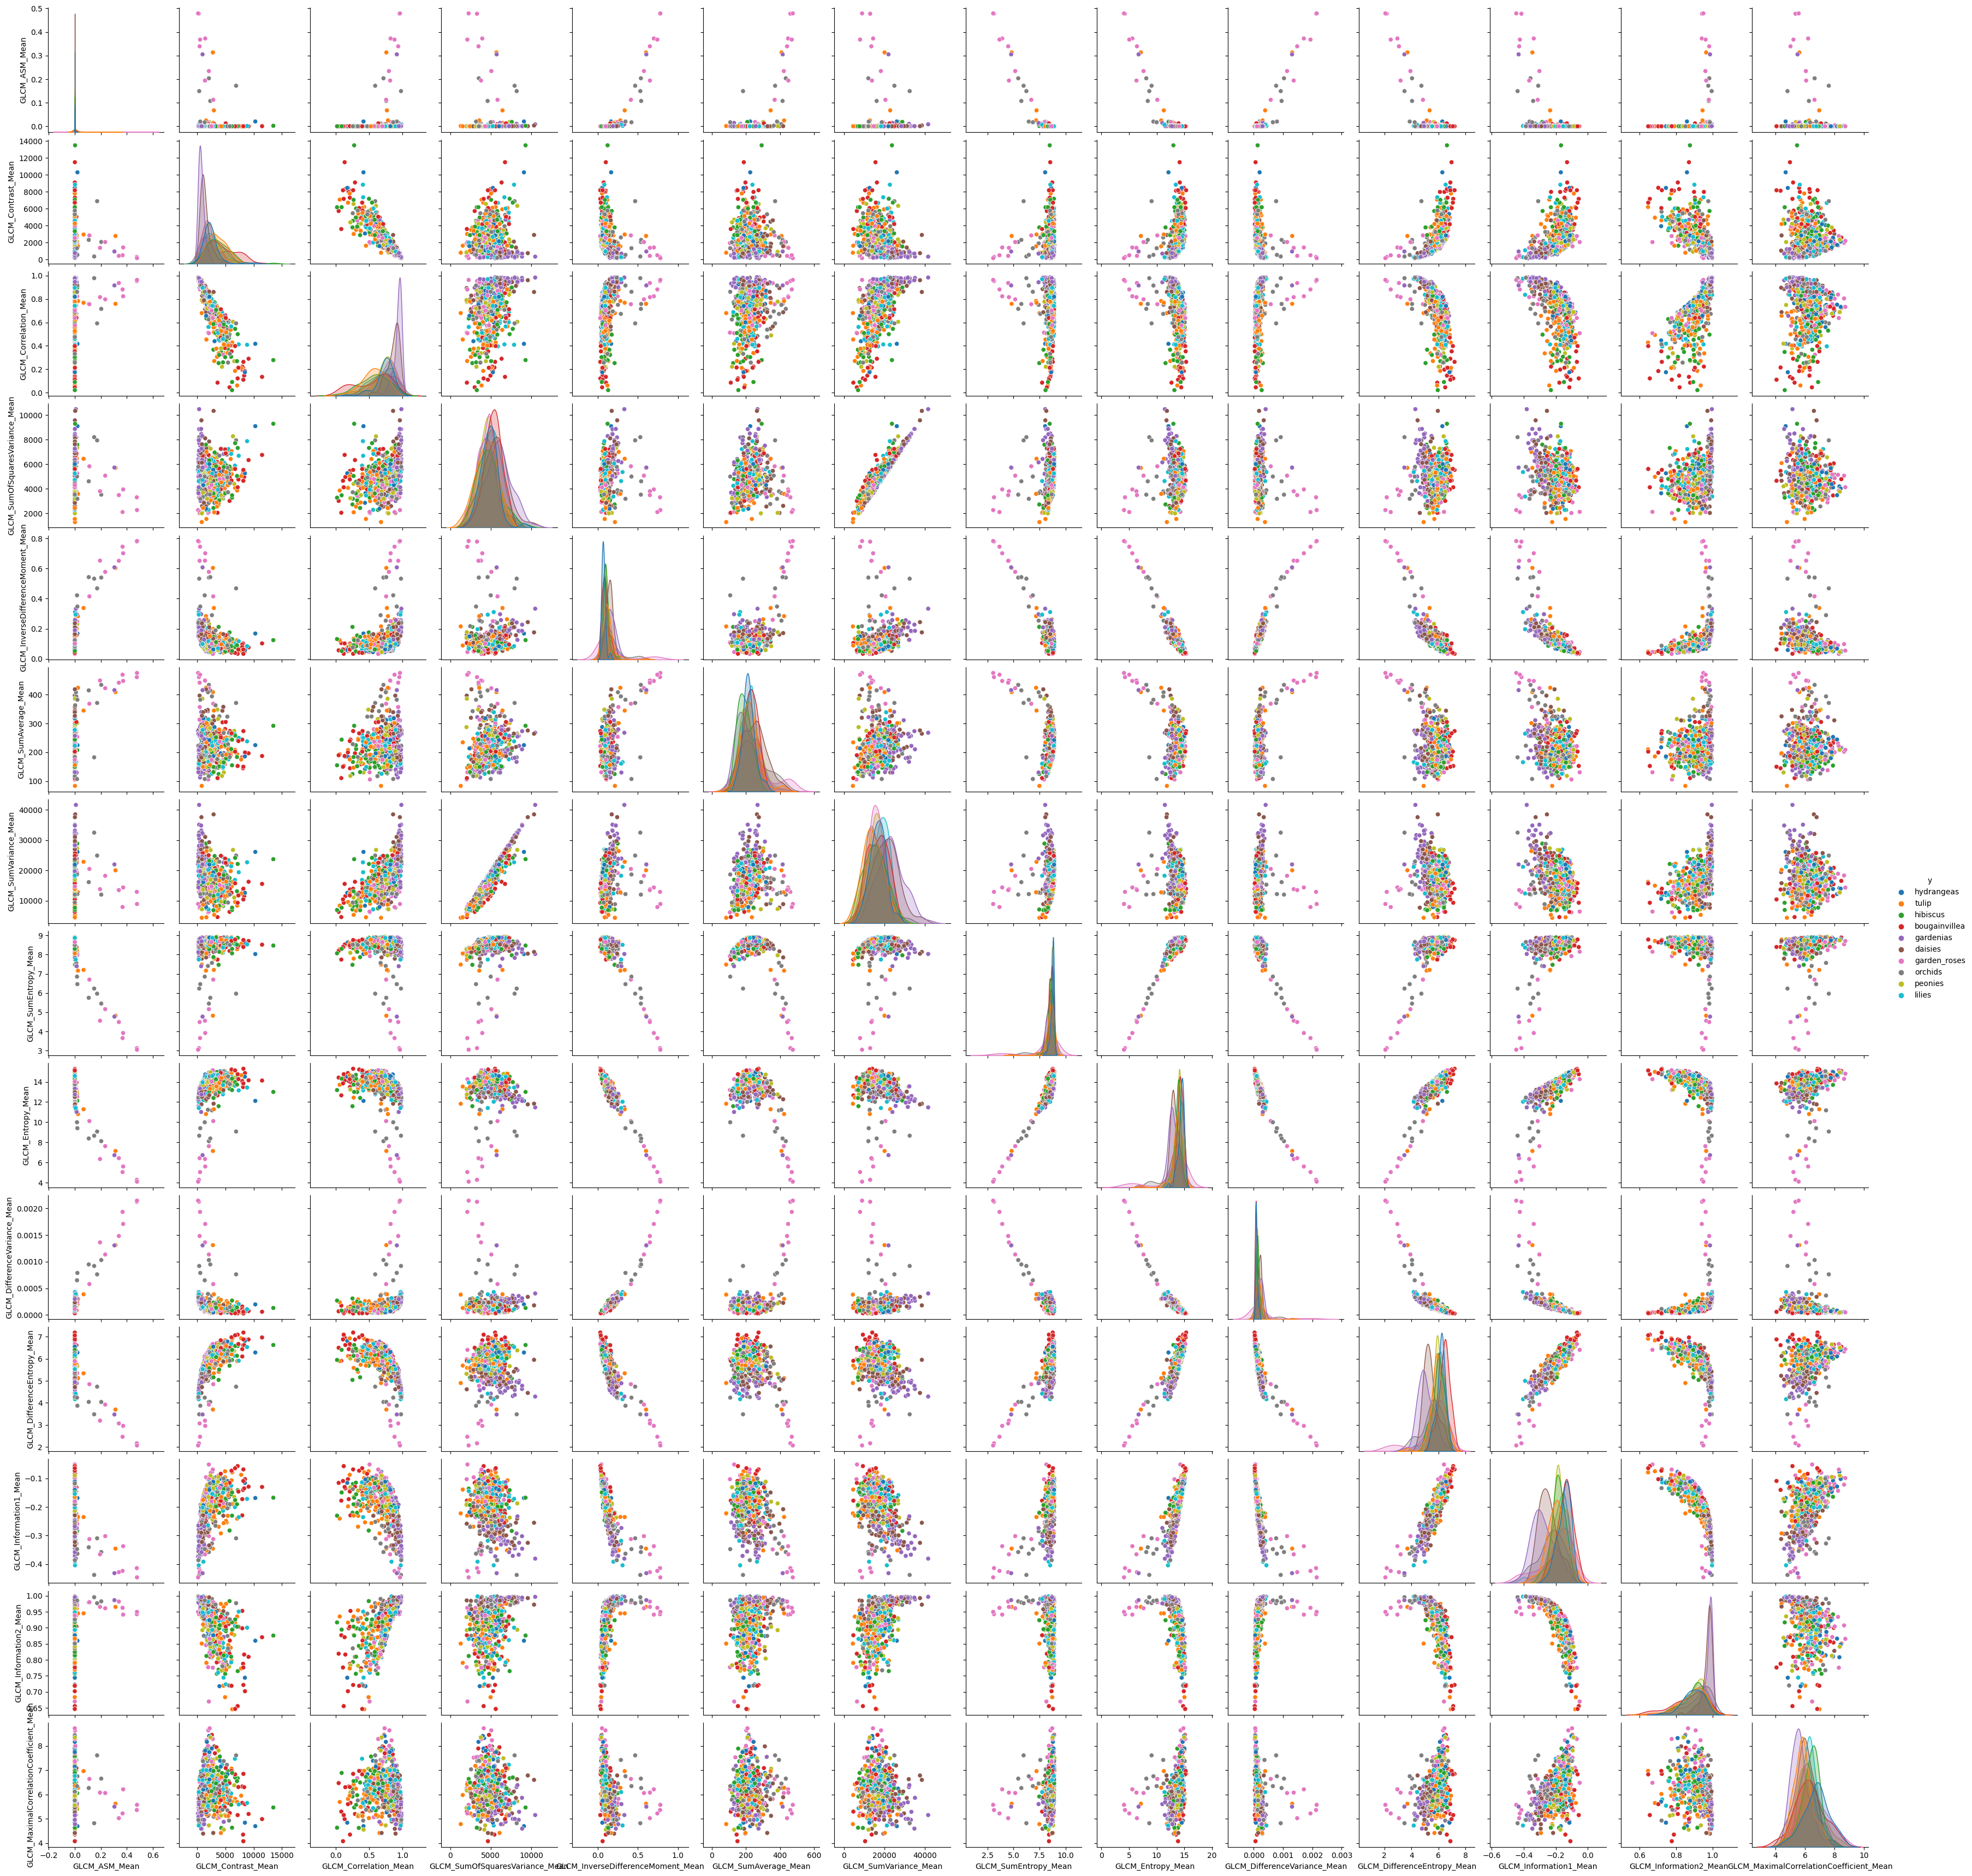

In [17]:
sns.pairplot(
    pd.concat((pd.DataFrame(X_train, columns=feat_labels), pd.DataFrame(y_train, columns=["y"])), axis=1),
    hue="y")

In [18]:
reduced_x = PCA(n_components=2).fit_transform(X_train)

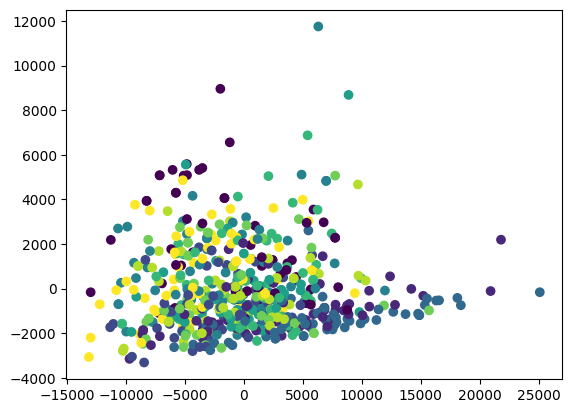

In [19]:
plt.scatter(reduced_x[:,0], reduced_x[:,1], c=enc.transform(y_train))

In [104]:
ray.shutdown()

## Law's Texture Mask

The filtered image should then be used to extract texture statistics such as:
1. Mean
2. Standard dev
3. Entropy
4. Absolute Mean

Whichever feature vector appropriated

In [16]:
from itertools import combinations_with_replacement

In [7]:
L = np.array([1,4,6,4,1])
E = np.array([-1, -2, 0, 2, 1])
S = np.array([-1,0,2,0,-1])
R = np.array([1, -4, 6, -4, 1])

In [18]:
np.outer(L,E)

array([[ -1,  -2,   0,   2,   1],
       [ -4,  -8,   0,   8,   4],
       [ -6, -12,   0,  12,   6],
       [ -4,  -8,   0,   8,   4],
       [ -1,  -2,   0,   2,   1]])

In [20]:
np.outer(E,L).T

array([[ -1,  -2,   0,   2,   1],
       [ -4,  -8,   0,   8,   4],
       [ -6, -12,   0,  12,   6],
       [ -4,  -8,   0,   8,   4],
       [ -1,  -2,   0,   2,   1]])

In [94]:
@ray.remote
def get_texture_map(file, masks, size):
    img = cv2.resize(
        read_image(file),
        size
    ).mean(axis=2)
    
    feat_img = np.zeros(( size[1], size[0], 9))
    
    for i in range(size[1]):
        for j in range(size[0]):   
            feat = []
            i_min, i_max = max(0, i-2), min(size[1], i+3)
            j_min, j_max = max(0, j-2), min(size[0], j+3)
            section = img[ i_min:i_max, j_min:j_max]
            
            i_range = i_max - i_min
            j_range = j_max - j_min
            
            ki, kj = 5 - i_range, 5 - j_range
            for flag, mask in masks:
                if flag:
                    
                    conv = (section * mask[ki:, kj:]).sum()
                else:
                    conv = ( 
                        (section * mask[ki:, kj:]) + 
                        (section * mask.T[ki:, kj:])
                    ) / 2
                    conv=conv.sum()
                feat.append(conv)
            feat_img[i,j] = np.array(feat)
                    
    return feat_img


def get_laws_masks():
    masks = []
    vectors = {
        "l": L, 
        "e": E,
        "s": S,
        "r": R
    }
    for pair in combinations_with_replacement(["l","e","s","r"], 2):
        if pair[0]!="l" or pair[1]!="l":
            mask = np.outer( vectors[ pair[0] ], vectors[ pair[1] ] )
            if (pair[0]==pair[1]):
                el = (True, mask)
            else:
                el = (False, mask)
            masks.append( el )
    return masks


def get_laws_texture(files, width=512, height=512):
    masks = get_laws_masks()
        
    res = []
    for file in files:
        size = (width, height)
        res.append( get_texture_map.remote(file, masks, size))
    X = ray.get(res)
    
    return X

In [95]:
textures = get_laws_texture(os.listdir(PATH)[:5])

In [99]:
textures[0][0,0]

array([2280.66666667,  508.66666667, 2040.66666667,  666.        ,
        152.66666667,  598.        ,   24.66666667,  156.66666667,
        398.        ])

In [100]:
from pyfeats.textural import lte_measures


In [162]:
lte_measures(
    cv2.resize(
        read_image(os.listdir(PATH)[0]),
        (512,512)
    ).mean(axis=2), mask=None, l=3
)

(array([537.45056759,  21.13178262,  23.50733985,  72.58154075,
         20.9998859 ,  54.76273849]),
 ['LTE_LL_3', 'LTE_EE_3', 'LTE_SS_3', 'LTE_LE_3', 'LTE_ES_3', 'LTE_LS_3'])